## 1. Clone the Git Repo

In [ ]:
!git clone https://github.com/hunter3789/VLM.git
%cd VLM
%pwd

Cloning into 'VLM'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 102 (delta 51), reused 37 (delta 20), pack-reused 17 (from 1)
Receiving objects: 100% (102/102), 43.96 MiB | 18.75 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Updating files: 100% (12/12), done.
/content/VLM


'/content/VLM'

## 2. Data pre-processing


[Raw data]
"stn_id": 133
"case": 2024-08-03 00:00:00
"data": [{'pres': 993.7, 'ta': 27.6, 'td': 26.5, 'u': 1.1, 'v': 1.2}, {'pres': 950, 'ta': 25.3, 'td': 24.7, 'gh': 515.7, 'wsd': 5.4, 'vec': 246.0, 'u': 4.9, 'v': 2.2}, {'pres': 925, 'ta': 24.5, 'td': 23.4, 'gh': 751.2, 'wsd': 6.6, 'vec': 245.8, 'u': 6.0, 'v': 2.7}, {'pres': 900, 'ta': 23.7, 'td': 21.5, 'gh': 992.3, 'wsd': 6.9, 'vec': 255.7, 'u': 6.7, 'v': 1.7}, {'pres': 850, 'ta': 21.0, 'td': 18.1, 'gh': 1491.8, 'wsd': 6.2, 'vec': 269.4, 'u': 6.2, 'v': 0.1}, {'pres': 800, 'ta': 18.1, 'td': 15.3, 'gh': 2015.7, 'wsd': 6.1, 'vec': 270.9, 'u': 6.1, 'v': -0.1}, {'pres': 700, 'ta': 12.7, 'td': 10.0, 'gh': 3150.3, 'wsd': 10.4, 'vec': 252.9, 'u': 9.9, 'v': 3.1}, {'pres': 600, 'ta': 6.6, 'td': 1.9, 'gh': 4434.8, 'wsd': 12.0, 'vec': 257.1, 'u': 11.7, 'v': 2.7}, {'pres': 500, 'ta': -1.6, 'td': -8.2, 'gh': 5911.3, 'wsd': 16.4, 'vec': 255.2, 'u': 15.9, 'v': 4.2}, {'pres': 400, 'ta': -12.7, 'td': -32.1, 'gh': 7650.3, 'wsd': 16.1, 'vec': 250.6, 'u'

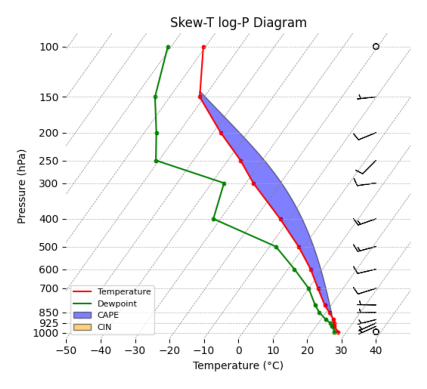


[Prompt generation]
{"system": "You are a weather forecaster analyzing atmospheric soundings shown in a Skew-T log-P diagram
The diagram uses a logarithmic vertical pressure axis (hPa), so pressure layers are not evenly spaced. Use the following visual anchors:
Lower layer (1000-850 hPa): This is located in the bottom quarter of the diagram, close to the surface. It represents the boundary layer where surface temperature, dew point, and CIN typically appear.
Mid layer (850-500 hPa): Appears in the second quarter from the bottom of the plot. This region often contains most of the CAPE and developing updrafts.
Upper layer (500-250 hPa): This is around the middle third of the diagram, despite covering less pressure range. This layer includes the top of convection (EL), cirrus clouds, and upper-level wind shear.
Use the following visual references:
Red line: temperature profile
Green line: dew point temperature
Blue shaded area: CAPE (Convective Available Potential Energy)
Yellow shaded a

In [ ]:
from source.tool_call import get_data, process_data, draw_skew, generate_prompt_response_vlm
import matplotlib.pyplot as plt

raw_data = get_data()
print("[Raw data]")
for key, value in raw_data.items():
    if key != 'image':
        print(f'"{key}": {value}')

processed_data = process_data(raw_data)
print("\n[Processed data]")
for key, value in processed_data.items():
    if key not in ['stn_id', 'case', 'rn3h', 'data', 'cape_polygon', 'cin_polygon']:
        print(f'"{key}": {value:.1f}')

# Plot Image
print("\n[Image]")
image = draw_skew(processed_data)
plt.imshow(image)
plt.axis('off')  # Optional: Hide axes
plt.show()

# VLM text generator
print("\n[Prompt generation]")
system_message, user_prompt, response = generate_prompt_response_vlm(processed_data)
print(f'{{"system": "{system_message}",\n')
print(f'"user": "{user_prompt}",\n')
print(f'"assistant": "{response}"}}')

## 3. Load the baseline VLM and the fine-tuned model


In [ ]:
from source.base_vlm import BaseVLM

vlm = BaseVLM()

# Load the model with LoRA adapters
from peft import PeftModel

ckpt_path = './model/vlm_curriculum_image_2.2B'
vlm.model = PeftModel.from_pretrained(vlm.model, ckpt_path, local_files_only=True).to(vlm.device)

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/modeling_auto.py:2160: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


## 4. Inference

In [ ]:
print("[Inference]")
response = vlm.answer([image], [system_message], [user_prompt], temperature = 0, use_images=True, use_image_path=False)
print(f'"assistant": "{response[0]}"')

[Inference]
"assistant": "The expansive and deep blue region (CAPE) reflects a highly unstable atmosphere, primed for thunderstorm formation. The setup may support severe storms if lifting and moisture are also sufficient.
The low start of the CAPE region reveals minimal inhibition for parcel ascent, encouraging convection even under weak surface forcing.
The blue region extends high into the upper atmosphere, indicating the potential for very tall convective towers and vigorous updrafts.
The boundary layer holds some humidity, which may support low-level cloud development.
Based on the analysis, the probability of precipitation is low."
